In [2]:
%run "0.0-antoniolml-import-libraries.ipynb"

/home/sathony/miniforge3/envs/missing_data_imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.assign` instead.
  return method(self._obj, *args, **kwargs)
/home/sathony/miniforge3/envs/missing_data_imputacion/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


# Importar Librerías

In [3]:
import janitor
import nhanes.load # encuesta de salud data
import numpy as np
import pandas as pd
import missingno

# Importar funciones personalizadas

In [4]:
%run "../missing_data_imputacion/utils/pandas-missing-extension.ipynb"

## Cargar los datos de NHANES

In [5]:
nhanes_raw_df=(
    nhanes.load.load_NHANES_data(year="2017-2018") # llamamos a los datas y expesificamos el año
    .clean_names(# para limpiar los nombres de las columnas agregando _ en los espacios
        case_type="snake" # cambiar estilo de columnas tipo snake
    )
)
nhanes_raw_df.shape

(8366, 197)

## Procesar los datos de NHANES

In [13]:
nhanes_df = (
    nhanes_raw_df.select_columns( # seleccionar un subconjunto de columnas
        "general_health_condition",
        "age_in_years_at_screening",
        "gender",
        "current_selfreported_height_inches",
        "current_selfreported_weight_pounds",
        "doctor_told_you_have_diabetes",
        "60_sec_pulse30_sec_pulse2",
        "total_cholesterol_mgdl"
    )
    .rename_columns( # renombrar las columnas
        {
            "age_in_years_at_screening": "age",
            "current_selfreported_height_inches": "height",
            "current_selfreported_weight_pounds": "weight",
            "doctor_told_you_have_diabetes": "diabetes",
            "60_sec_pulse30_sec_pulse2": "pulse",
            "total_cholesterol_mgdl": "total_cholesterol"
        }
    )
    .replace( # reemplazar valores faltantes que no son NaN
        {
            "height": {
                9999: np.nan,
                7777: np.nan
            },
            "weight": {
                9999: np.nan,
                7777: np.nan
            },
            "diabetes": {
                "Borderline": np.nan
            }
        }
    )
    .missing.sort_variables_by_missingness() # para visualizar rapidamente las columnas que tienen valores faltantes y cuales son los queno.
    .dropna( # eliminar la columna diabetes
        subset = ["diabetes"],
        how = "any" # en cualquier oparición que esta observacion tenga  un dato nulo
    )
    .transform_column( #diabetes nos marca como objet, y necesitamos transformarla a int
        column_name = "diabetes", # nombre de la columna
        function = lambda s: s.astype(int), #funcion que transforma la columna a int
        elementwise = False #nos regresa una serie y no un elemento
    )
)

nhanes_df

/home/sathony/miniforge3/envs/missing_data_imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
SEQN,,,,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Female
93704.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Male
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
...,...,...,...,...,...,...,...,...
102951.0,NaN,NaN,NaN,NaN,NaN,0,4.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


## Visualizar los valores faltantes

/home/sathony/miniforge3/envs/missing_data_imputacion/lib/python3.9/site-packages/missingno/missingno.py:72: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax0.grid(b=False)
/home/sathony/miniforge3/envs/missing_data_imputacion/lib/python3.9/site-packages/missingno/missingno.py:141: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=False)


<AxesSubplot:>

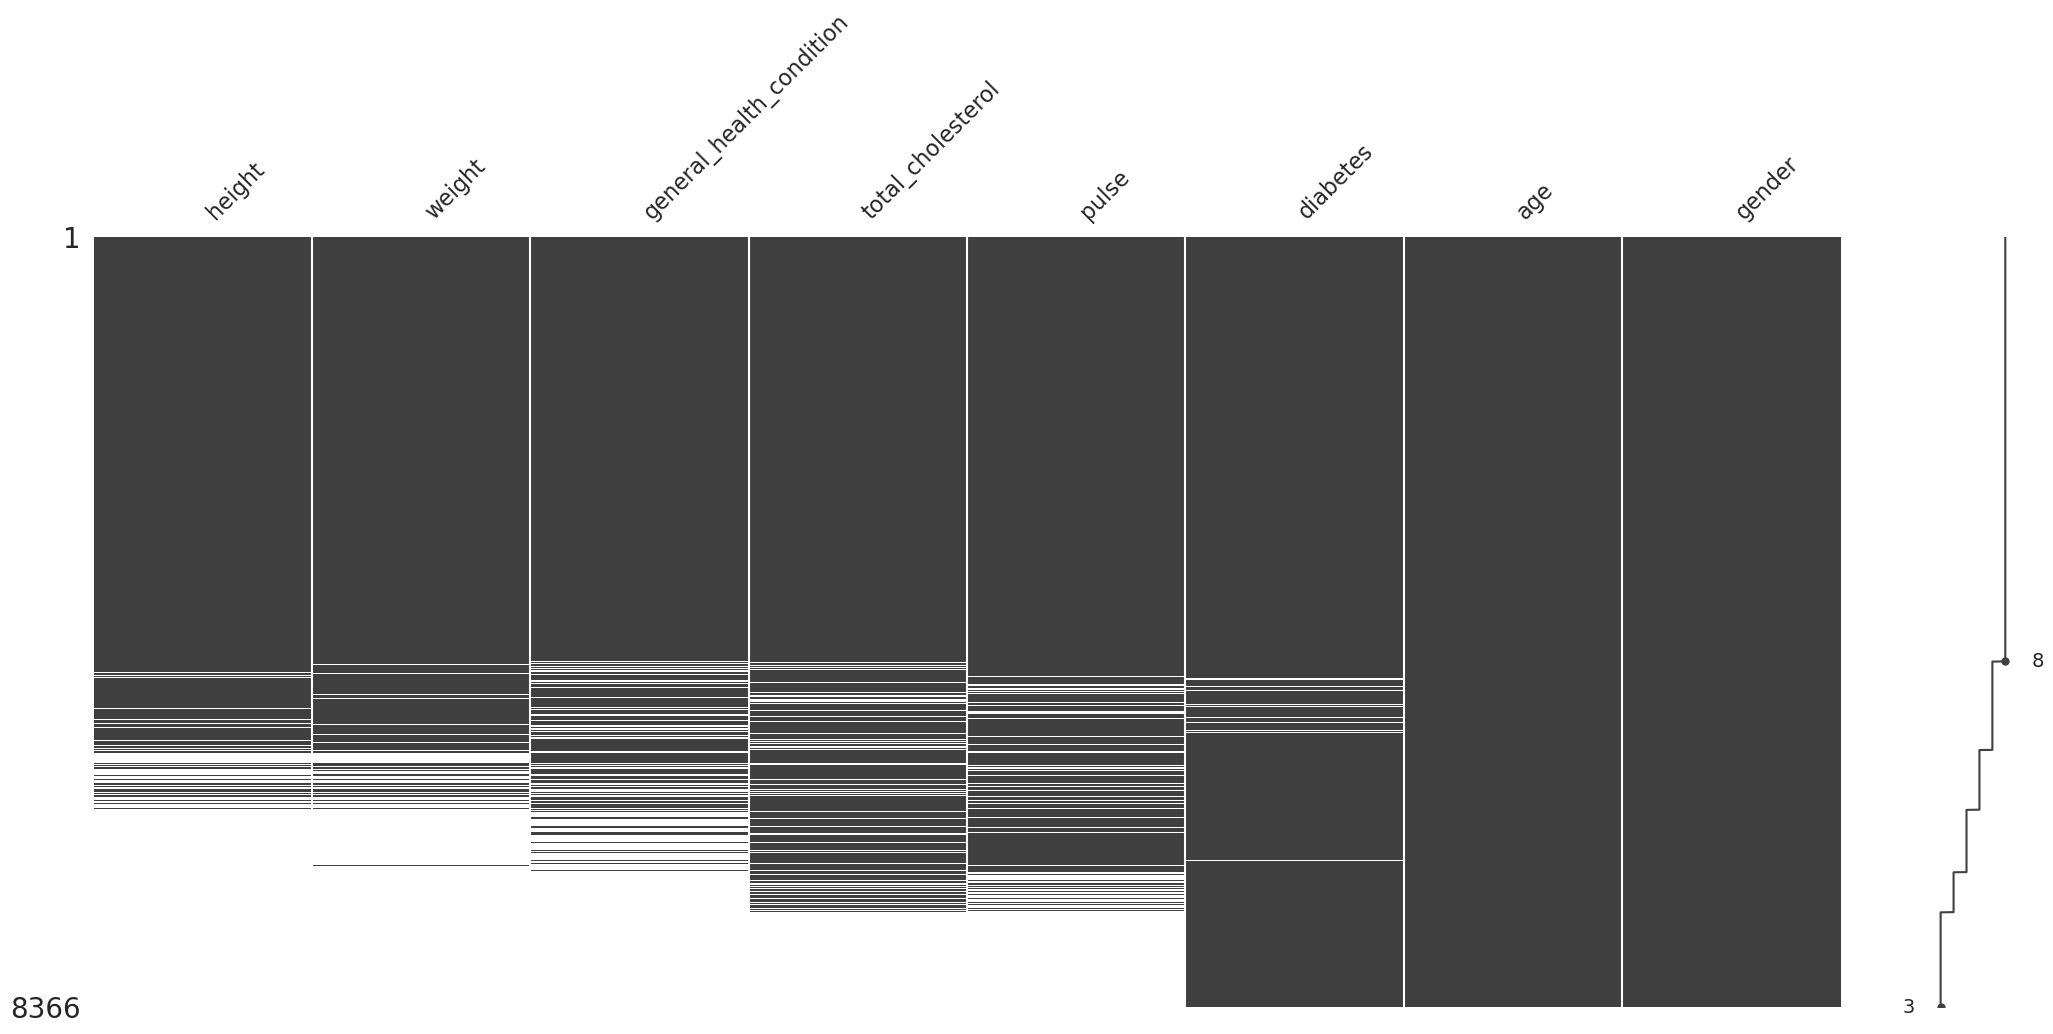

In [7]:
(
    nhanes_df #conjunto de datos
    .missing.sort_variables_by_missingness() # accedemos a nuestra extension missing y ordernamos por datos faltantes
    .pipe(missingno.matrix, sort="descending") # visualizamos los datos faltantes usando missingno.matrix de manera descendente
)

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

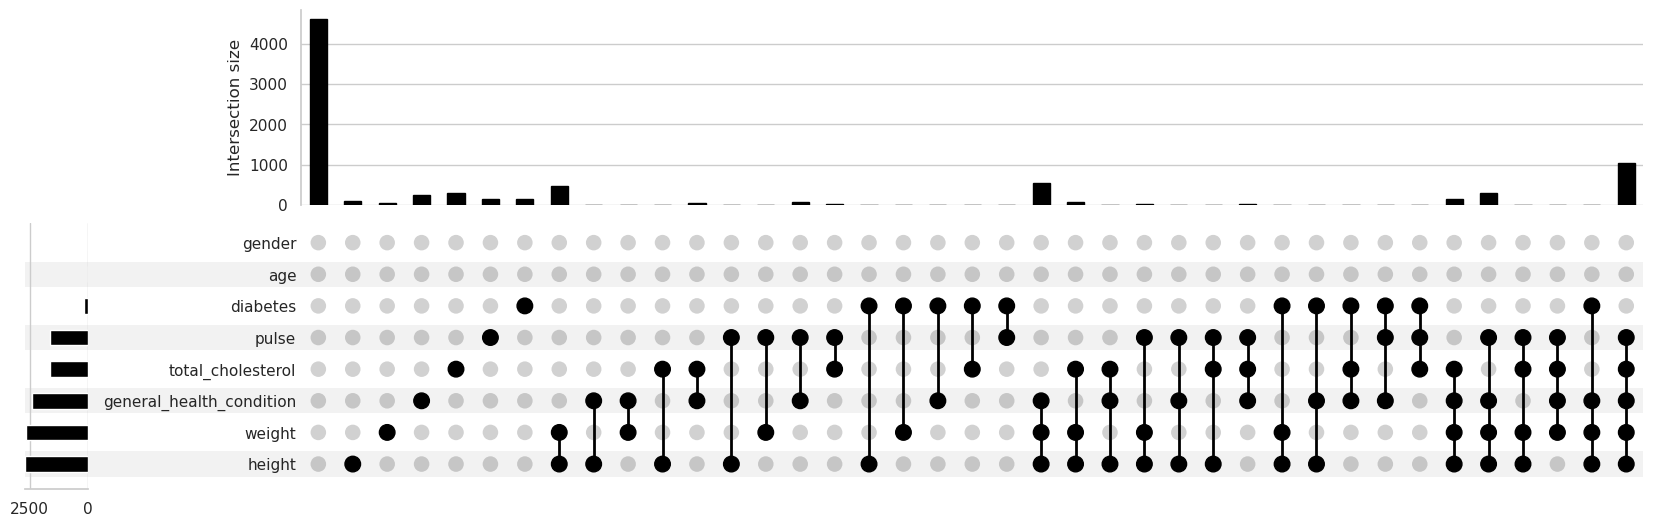

In [8]:
(
    nhanes_df
    .missing.sort_variables_by_missingness()
    .missing.missing_upsetplot() # visualizamos los datos faltantes usando missingno.upsetplot
)
# primera columna puros puntitos en griss eso quiere decir que no hay valores faltantes, por vemos que en la ultima columna hay cerca de 1k de valores faltantes, lo cual podemos decidir eliminar o imputarlo. 

/home/sathony/miniforge3/envs/missing_data_imputacion/lib/python3.9/site-packages/missingno/missingno.py:72: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax0.grid(b=False)
/home/sathony/miniforge3/envs/missing_data_imputacion/lib/python3.9/site-packages/missingno/missingno.py:141: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=False)


<AxesSubplot:>

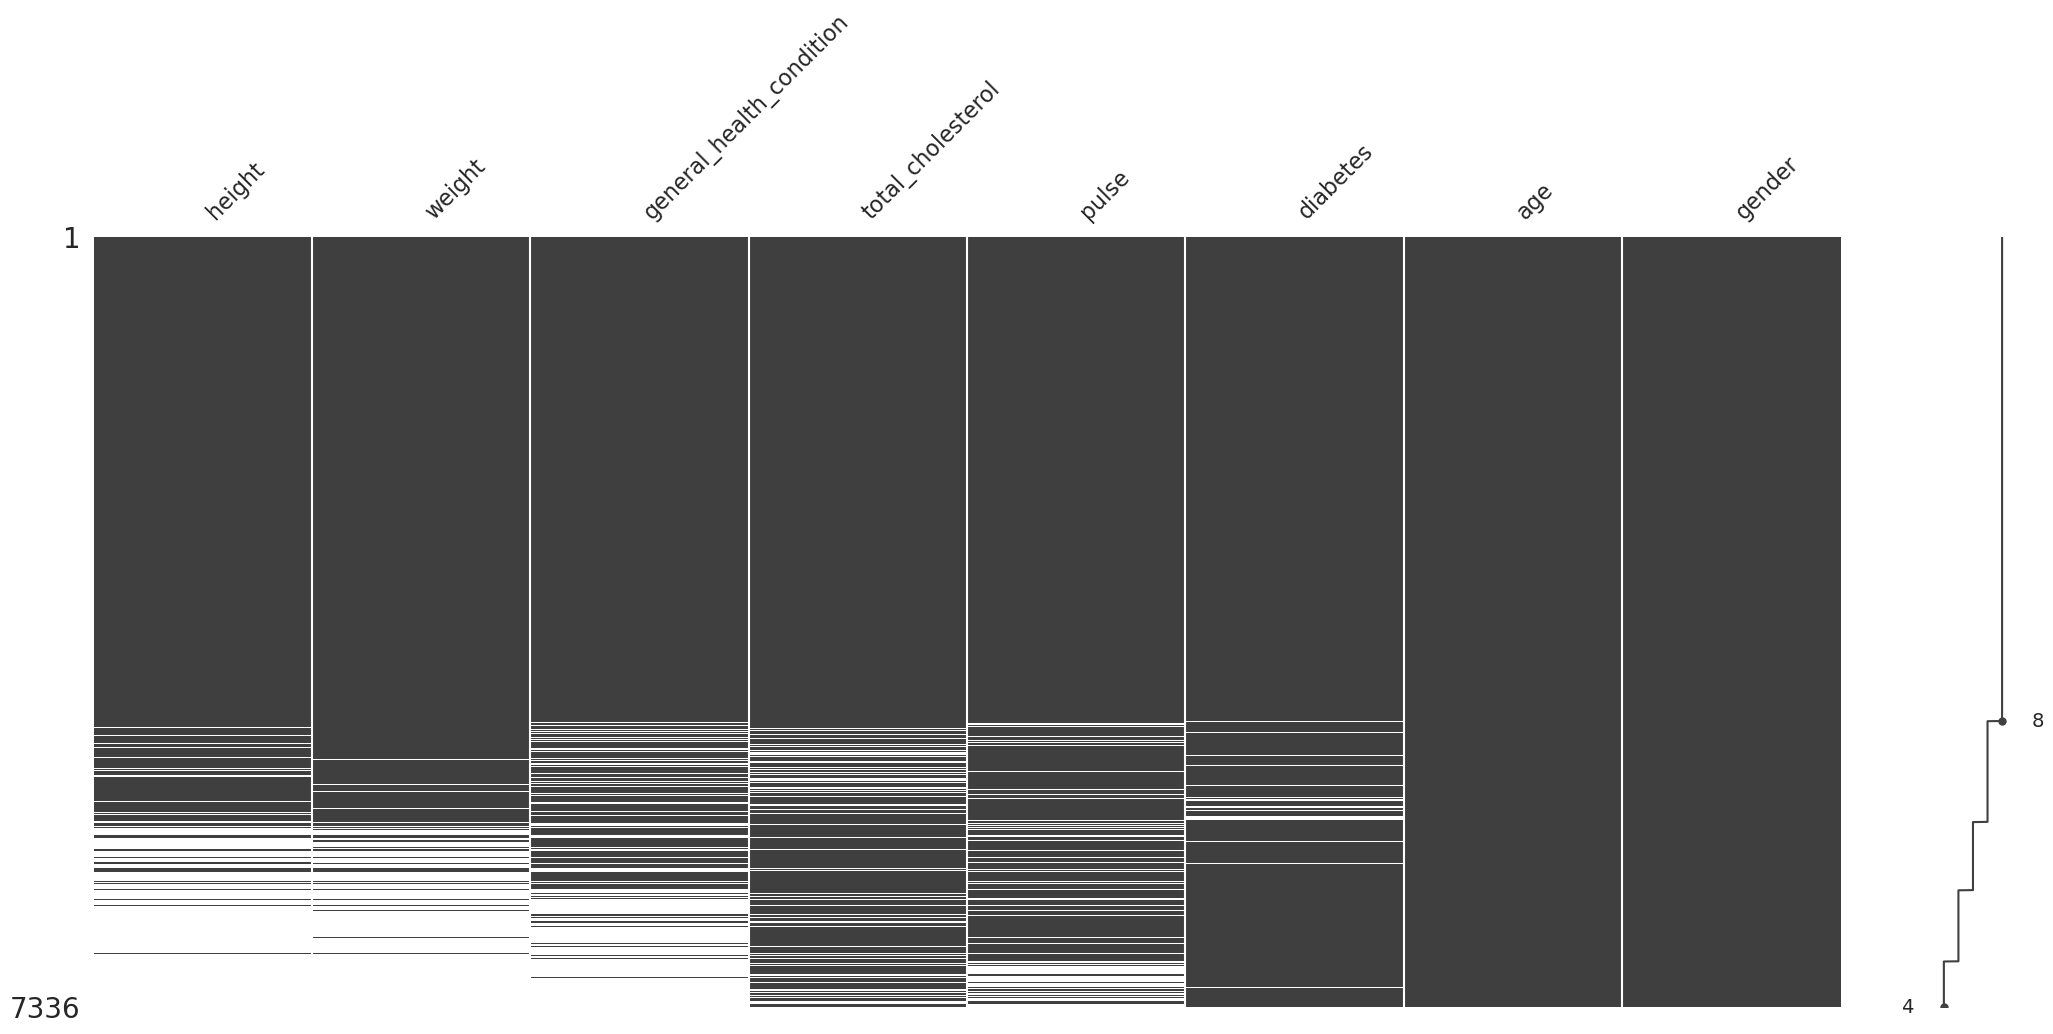

In [9]:
(
    nhanes_df
    .dropna( # eliminamos las observaciones que tengan valores faltantes
        subset = ["pulse", "total_cholesterol", "general_health_condition", "weight", "height"],
        how = "all" # solo si los valores faltantes estan en estas 5 columnas elimina la fila, si no, no.
    )
    .missing.sort_variables_by_missingness() # ordenar
    .pipe(lambda df: missingno.matrix(df, sort="descending")) # visualizar
) # lo que vemos es que ya no hay esos espacios en blancos que teniamos en la figura anterior

# Eliminar valores faltantes

In [10]:
nhanes_df = (
    nhanes_df
    .dropna(
        subset = ["pulse", "total_cholesterol", "general_health_condition", "weight", "height"],
        how = "all"
    )
)

nhanes_df.shape

(7336, 8)